In [1]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 245
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

# Modeling with a hierarchical 2D covariate with additional varying levels

This notebook is to experiment with creating a hierarchical covariate with 2 dimensions: gene $\times$ cell line.
Each value in the matrix will come from a model of two varying covariables, one for the gene and one for the cell line.
The cell line covariate will then come from a distribution of the lineage as another level in the model.

## Data preparation

I will need a fair amount of data to fit a model with so many parameters, but I will still start with a subsample of the full data set.

In [2]:
NUM_GENES = 20
NUM_LINEAGES = 5

data_path = Path("../modeling_data")
starting_dataset_path = data_path / "depmap_modeling_dataframe.csv"
final_dataset_path = (
    data_path / "subsample_covariate-matrix_depmap-modeling-dataframe.csv"
)

if final_dataset_path.exists() and False:
    # Read in data set that has already been created.
    print("Reading in existing file.")
    modeling_data = pd.read_csv(final_dataset_path)
else:
    # Read in full data set and subsample some genes and lineages.
    print(
        f"Subsampling {NUM_GENES} genes and {NUM_LINEAGES} lineages from full dataset."
    )
    full_modeling_data = pd.read_csv(starting_dataset_path, low_memory=False)

    GENES = np.random.choice(full_modeling_data.hugo_symbol.unique(), NUM_GENES)
    LINEAGES = np.random.choice(full_modeling_data.lineage.unique(), NUM_LINEAGES)

    modeling_data = full_modeling_data[full_modeling_data.hugo_symbol.isin(GENES)]
    modeling_data = modeling_data[modeling_data.lineage.isin(LINEAGES)]
    modeling_data = modeling_data.reset_index(drop=True)

    modeling_data.to_csv(final_dataset_path)
    del full_modeling_data

Subsampling 20 genes and 5 lineages from full dataset.


In [3]:
print("Genes:")
print(modeling_data.hugo_symbol.unique().tolist())

print("-" * 60)
print("Lineages:")
print(modeling_data.lineage.unique().tolist())

Genes:
['C18orf54', 'ARG1', 'DHDH', 'RGPD6', 'H3F3A', 'STRC', 'GIPR', 'FAM206A', 'YPEL5', 'GTF2E1', 'AAED1', 'LGI3', 'ZNF175', 'ARHGAP26', 'IL17B', 'HERC1', 'PLEKHH3', 'NACC2', 'PRKAR1A', 'CT47A7']
------------------------------------------------------------
Lineages:
['blood', 'upper_aerodigestive', 'colorectal', 'liver']


In [4]:
modeling_data.shape

(22960, 27)

In [5]:
modeling_data.head(5)

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,log2_gene_cn_p1,gene_cn,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
0,AAGAAAAACAAGAAATGCCG,697-311cas9_repa_p6_batch3,-0.317445,3,True,ACH-000070,Primary,blood,ALL,WT,...,0.985476,1.679088,0,False,NaN,NaN,NaN,NaN,False,2.629939
1,AAGCATCTCTGGCCATGCCA,697-311cas9_repa_p6_batch3,0.216901,3,True,ACH-000070,Primary,blood,ALL,WT,...,0.971533,1.641990,0,False,NaN,NaN,NaN,NaN,False,0.000000
2,ACAGAAACACGACATCCCCA,697-311cas9_repa_p6_batch3,0.014907,3,True,ACH-000070,Primary,blood,ALL,WT,...,1.009784,1.745008,0,False,NaN,NaN,NaN,NaN,False,0.056584
3,ACTCACCTGTCGAGGCGACG,697-311cas9_repa_p6_batch3,-0.987370,3,True,ACH-000070,Primary,blood,ALL,WT,...,NaN,NaN,0,False,NaN,NaN,NaN,NaN,False,0.454176
4,ACTGCCCGCAAATCGACCGG,697-311cas9_repa_p6_batch3,-0.712884,3,True,ACH-000070,Primary,blood,ALL,WT,...,1.300406,2.670787,1,False,missense_mutation,FALSE,FALSE,TRUE,False,10.285865


In [9]:
for col in [
    "sgrna",
    "pdna_batch",
    "depmap_id",
    "lineage",
    "kras_mutation",
    "hugo_symbol",
]:
    modeling_data = dphelp.make_cat(modeling_data, col, ordered=True, sort_cats=True)

## Data visualization

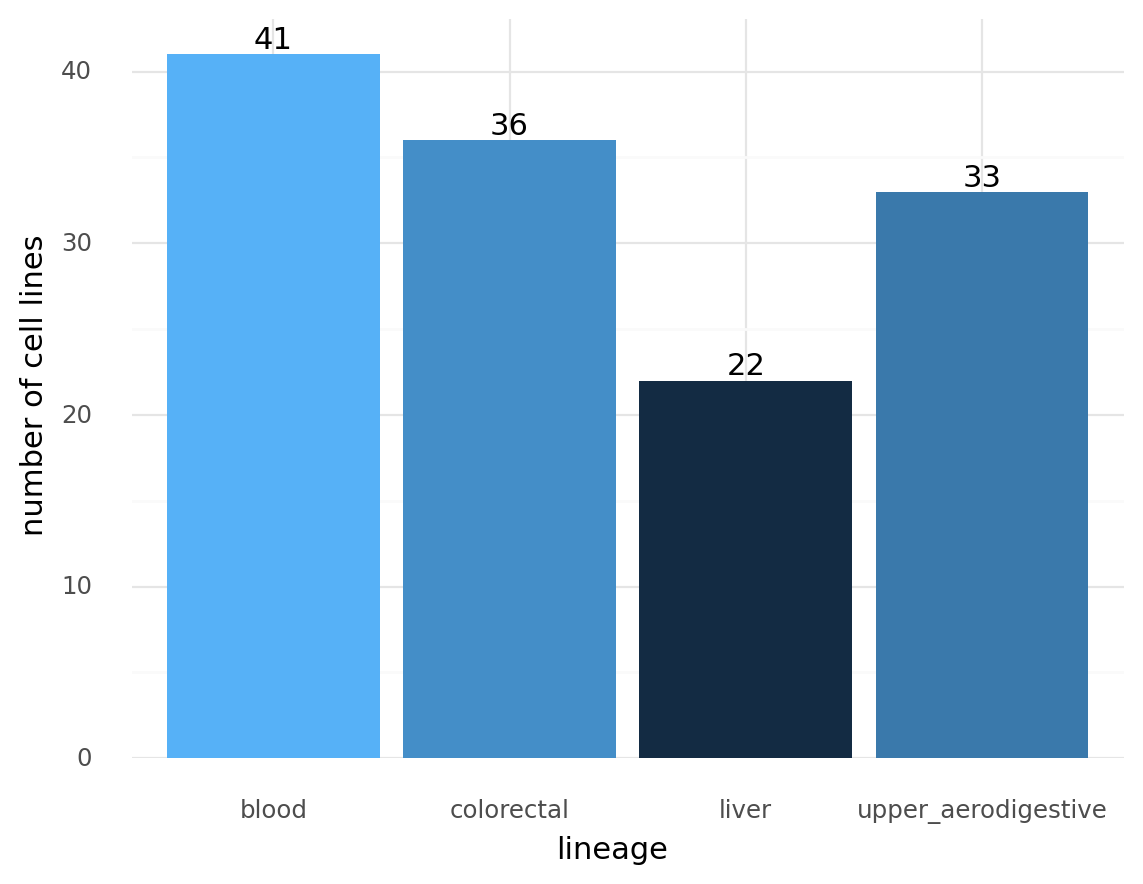

<ggplot: (8765464161009)>

In [25]:
plot_data = (
    modeling_data[["lineage", "depmap_id"]]
    .drop_duplicates()
    .groupby("lineage")
    .count()
    .reset_index()
)

(
    gg.ggplot(plot_data, gg.aes("lineage", "depmap_id"))
    + gg.geom_col(gg.aes(fill="depmap_id"))
    + gg.geom_text(gg.aes(label="depmap_id"), va="bottom")
    + gg.scale_fill_gradient(guide=None)
    + gg.scale_y_continuous(expand=(0, 0, 0.05, 0))
    + gg.labs(x="lineage", y="number of cell lines")
)

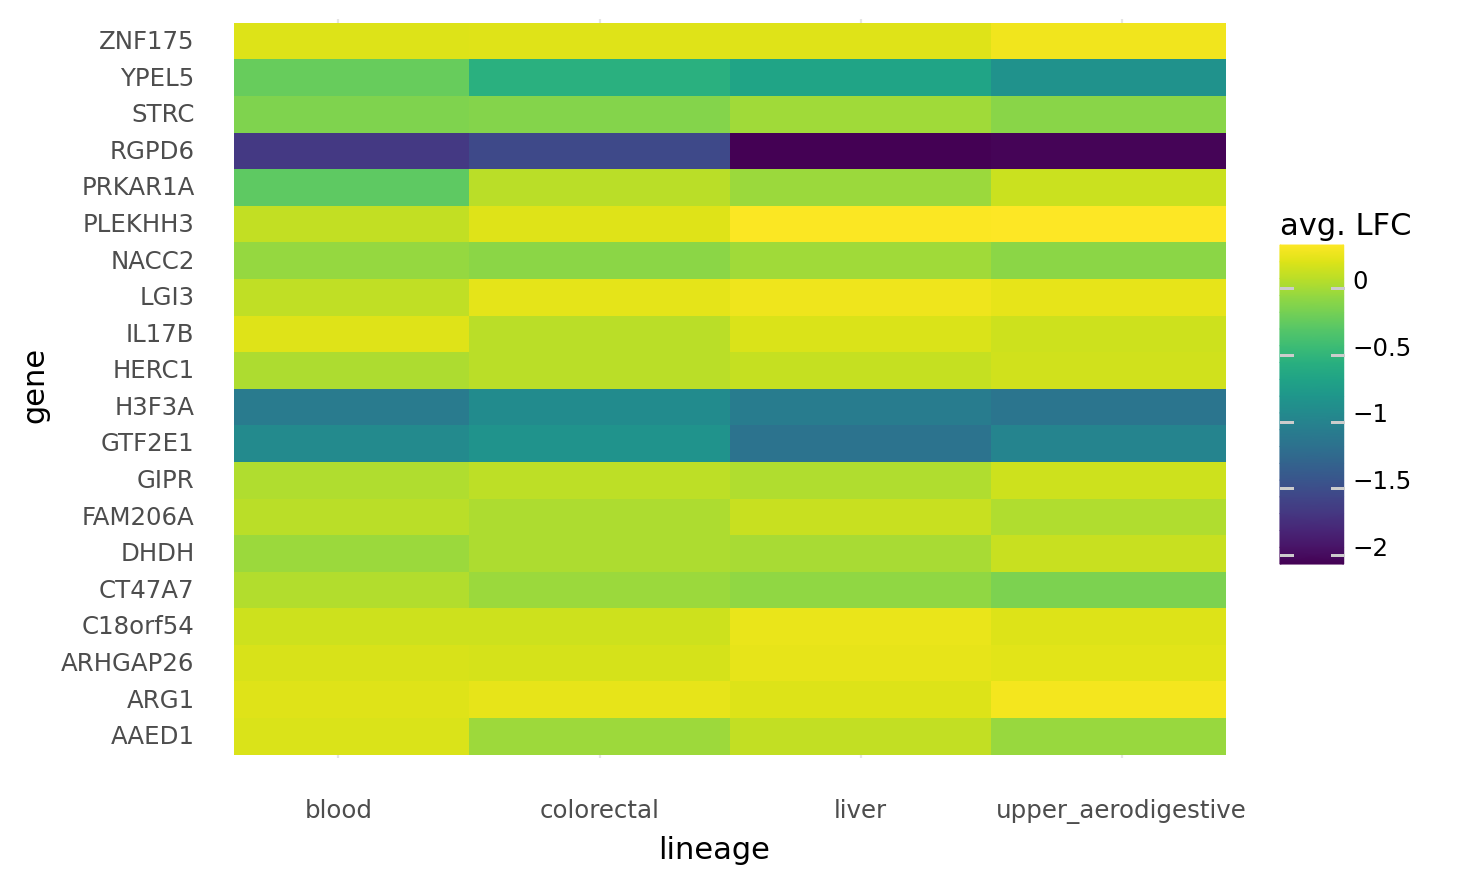

<ggplot: (8765464171945)>

In [37]:
plot_data = (
    modeling_data[["lineage", "hugo_symbol", "lfc"]]
    .groupby(["lineage", "hugo_symbol"])
    .mean()
    .reset_index()
)

(
    gg.ggplot(plot_data, gg.aes(x="lineage", y="hugo_symbol", fill="lfc"))
    + gg.geom_tile()
    + gg.scale_x_discrete(expand=(0.1, 0.1))
    + gg.labs(x="lineage", y="gene", fill="avg. LFC")
)

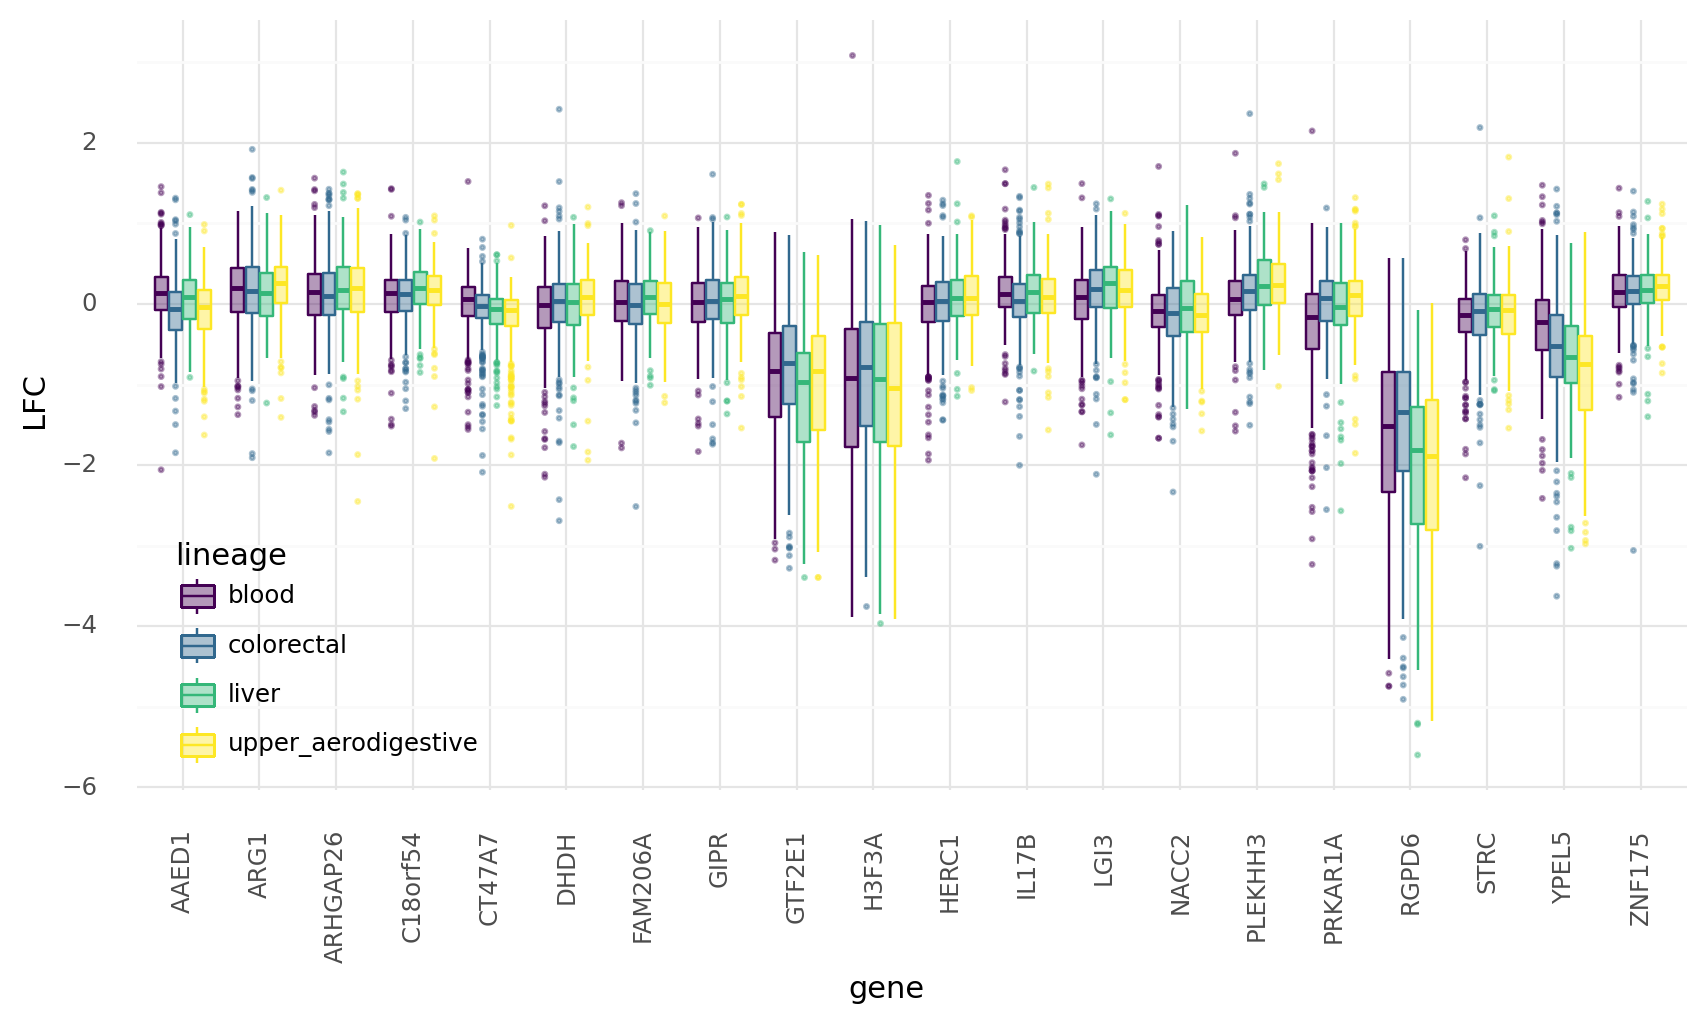

<ggplot: (8765464034314)>

In [45]:
(
    gg.ggplot(modeling_data, gg.aes(x="hugo_symbol", y="lfc"))
    + gg.geom_boxplot(
        gg.aes(color="lineage", fill="lineage"),
        alpha=0.4,
        outlier_alpha=0.4,
        outlier_size=0.4,
    )
    + gg.theme(
        figure_size=(10, 5),
        axis_text_x=gg.element_text(angle=90),
        legend_position=(0.22, 0.25),
    )
    + gg.labs(x="gene", y="LFC", fill="lineage")
)

---

In [46]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 28.69 minutes


In [47]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-27

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-230.o2.rc.hms.harvard.edu

Git branch: data-subset-model

seaborn   : 0.11.1
plotnine  : 0.7.1
matplotlib: 3.3.3
re        : 2.2.1
numpy     : 1.19.5
pymc3     : 3.9.3
arviz     : 0.11.0
theano    : 1.0.5
pandas    : 1.2.0

